# Proyek Klasifikasi Gambar: Plant Village
- **Nama:** Novianti Safitri
- **Email:** noviantis112@gmail.com
- **ID Dicoding:** novianti_safitri

## Import Semua Packages/Library yang Digunakan

In [1]:
!pip install tensorflowjs
!pip install kaggle

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 16.5 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.6
    Uninstalling protobuf-4.25.6:
      Successfully uninstalled protobuf-4.25.6
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2


In [2]:
import os
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflowjs as tfjs
import pathlib
from tensorflow.keras import layers, models, Input, Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from google.colab import files
import zipfile

## Data Preparation

### Data Loading

In [3]:
files.upload()  # Upload kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"noviantisafitri","key":"941226fd0508106c46d775e7ad35a1ba"}'}

In [4]:
# Setup Kaggle API
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
# Download dataset dari Kaggle
!kaggle datasets download -d arjuntejaswi/plant-village

Dataset URL: https://www.kaggle.com/datasets/arjuntejaswi/plant-village
License(s): unknown
 97% 320M/329M [00:01<00:00, 244MB/s]
100% 329M/329M [00:01<00:00, 240MB/s]


In [6]:
# Ekstrak dataset
dataset_path = "/content/PlantVillage"
os.makedirs(dataset_path, exist_ok=True)

with zipfile.ZipFile("plant-village.zip", 'r') as zip_ref:
    zip_ref.extractall(dataset_path)

print("Ekstraksi selesai!")
print(os.listdir(dataset_path))

Ekstraksi selesai!
['PlantVillage']


In [7]:
# Path dataset yang sesuai untuk Colab
output_path = "/content/PotatoDataset"
os.makedirs(output_path, exist_ok=True)

In [8]:
# Copy folder yang berawalan "Potato_" ke direktori baru
for folder in os.listdir(dataset_path + "/PlantVillage"):
    if folder.startswith("Potato_"):
        shutil.copytree(os.path.join(dataset_path, "PlantVillage", folder), os.path.join(output_path, folder))

print("Potato folders copied successfully!")

Potato folders copied successfully!


In [9]:
# Constants
BATCH_SIZE = 32
IMAGE_SIZE = 224
CHANNELS = 3
EPOCHS = 20

In [10]:
# Load dataset ke dalam format TensorFlow
tensor_ds = tf.keras.utils.image_dataset_from_directory(
    output_path,
    seed=123,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
)

print("Potato dataset loaded successfully!")

Found 2152 files belonging to 3 classes.
Potato dataset loaded successfully!


Classes: ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


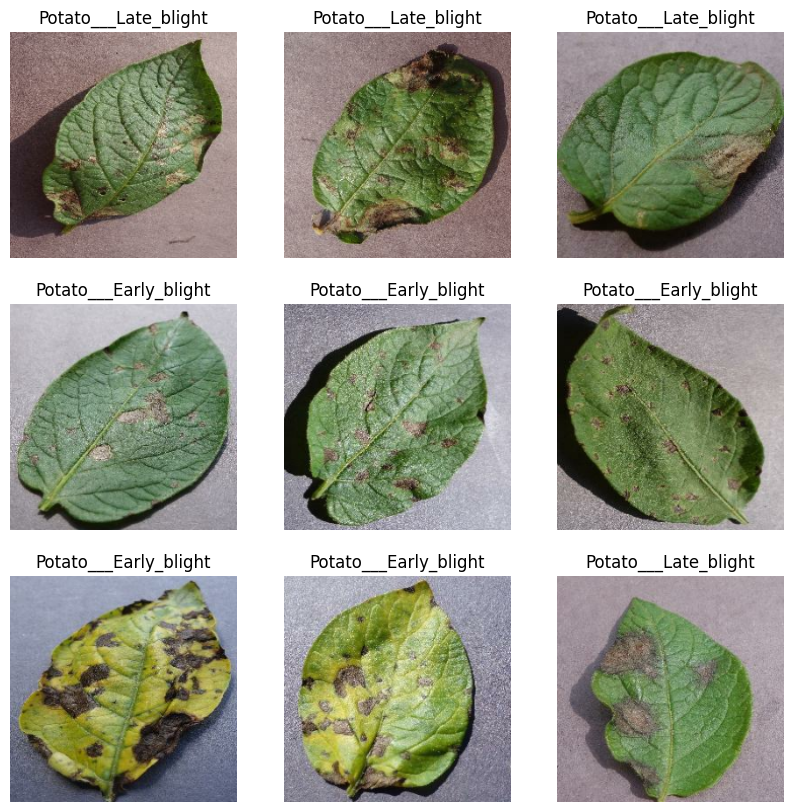

In [11]:
# Visualisasi beberapa gambar
class_names = tensor_ds.class_names
print("Classes:", class_names)

plt.figure(figsize=(10, 10))
for images, labels in tensor_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Data Preprocessing

#### Split Dataset

In [12]:
# Fungsi untuk membagi dataset
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions_tf(tensor_ds)

In [13]:
# Optimasi dataset
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Modelling

In [14]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

In [15]:
# Model CNN
resize_and_rescale = Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255),
])

data_augmentation = Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y)).prefetch(buffer_size=tf.data.AUTOTUNE)

input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)  # Tanpa batch size
n_classes = len(class_names)

model = models.Sequential([
    Input(shape=input_shape),
    resize_and_rescale,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

In [16]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 43264)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       2,768,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,825,475 (10.78 MB)

 Trainable params: 2,825,475 (10.78 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Compile model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train model dengan callbacks
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[early_stopping, reduce_lr]  # Callbacks
)

Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 187s 3s/step - accuracy: 0.6170 - loss: 0.8905 - val_accuracy: 0.8750 - val_loss: 0.4902 - learning_rate: 0.0010
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 177s 3s/step - accuracy: 0.8619 - loss: 0.3677 - val_accuracy: 0.9271 - val_loss: 0.2078 - learning_rate: 0.0010
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 175s 3s/step - accuracy: 0.9084 - loss: 0.2186 - val_accuracy: 0.9427 - val_loss: 0.1528 - learning_rate: 0.0010
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 177s 3s/step - accuracy: 0.9182 - loss: 0.1859 - val_accuracy: 0.9167 - val_loss: 0.1843 - learning_rate: 0.0010
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 173s 3s/step - accuracy: 0.9324 - loss: 0.1640 - val_accuracy: 0.9688 - val_loss: 0.0779 - learning_rate: 0.0010
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 179s 3s/step - accuracy: 0.9614 - loss: 0.1012 - val_accuracy: 0.8854 - val_loss: 0.3441 - learning_rate: 0.0010
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 172s 3s/step - accuracy: 0.9340 - loss: 0.1906 - val_acc

## Evaluasi dan Visualisasi

In [18]:
# Evaluasi model pada training set
train_loss, train_acc = model.evaluate(train_ds)
print(f"Training Accuracy: {train_acc * 100:.2f}%")

# Evaluasi model pada testing set
test_loss, test_acc = model.evaluate(test_ds)
print(f"Testing Accuracy: {test_acc * 100:.2f}%")

54/54 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.9831 - loss: 0.0522
Training Accuracy: 98.61%
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 765ms/step - accuracy: 0.9591 - loss: 0.1002
Testing Accuracy: 96.48%


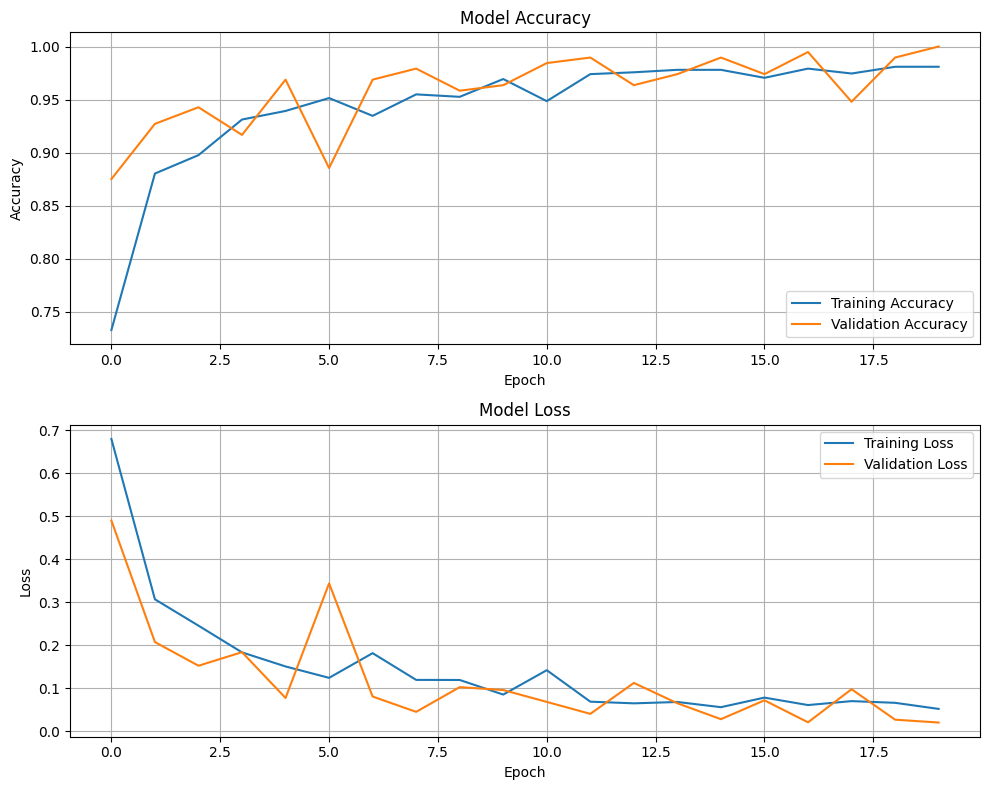

In [19]:
# Plot Akurasi dan Loss
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Plot akurasi
axs[0].plot(history.history['accuracy'], label='Training Accuracy')
axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axs[0].set_title('Model Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].legend(loc='lower right')
axs[0].grid()

# Plot loss
axs[1].plot(history.history['loss'], label='Training Loss')
axs[1].plot(history.history['val_loss'], label='Validation Loss')
axs[1].set_title('Model Loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].legend(loc='upper right')
axs[1].grid()

# Tampilkan plot
plt.tight_layout()
plt.show()

## Konversi Model

In [24]:
os.makedirs("saved_model", exist_ok=True)
os.makedirs("tflite", exist_ok=True)
os.makedirs("tfjs_model", exist_ok=True)

# Simpan model dalam format SavedModel
model.export("saved_model")  # Menggunakan export() yang benar
print("Model saved in SavedModel format.")

# Konversi dan simpan model ke format TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
tflite_path = "tflite/model.tflite"

with open(tflite_path, "wb") as f:
    f.write(tflite_model)
print("Model saved in TF-Lite format.")

# Simpan label kelas dalam tflite/label.txt
class_names = ["Potato___Early_blight", "Potato___Late_blight", "Potato___healthy"]
with open("tflite/label.txt", "w") as f:
    for label in class_names:
        f.write(label + "\n")
print("Labels saved in tflite/label.txt.")

# Konversi dan simpan model ke format TensorFlow.js
tfjs.converters.save_keras_model(model, "tfjs_model")
print("Model saved in TensorFlow.js format.")

Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_3')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  139773069364304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139773069365072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139773069364496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139773069366608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139773069367568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139773069366800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139773069365456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139773069368528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139773069367184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139773069369296: TensorSpec(shape=(), dtype=tf.resource, name=None)
Model saved in Save

Model saved in TF-Lite format.
Labels saved in tflite/label.txt.
failed to lookup keras version from the file,
    this is likely a weight only file
Model saved in TensorFlow.js format.
